In [11]:
from ngsolve import *
## choose this option to draw in interactive window or jupyter
from ngsolve.webgui import Draw
## choose this option for a separate gui window
# import netgen.gui


In [12]:
from ngsolve.meshes import MakeStructured2DMesh
import numpy as np

import matplotlib.pyplot as plt

### The mesh
structured mesh for square domain

In [13]:
radius = 30
height = 30

def transformation(x, y): return (radius*x, height*y)
# def transformation(x, y): return (radius*(1-(1-x)**2), height*y**2)

mesh = MakeStructured2DMesh(quads=True, nx=10, ny=10, mapping=transformation)
Draw(mesh)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

### Elastic parameters & external load

In [14]:
## Elastic modulus
Emodul = 2  ## N/mm^2
## Poisson ratio
nu = 0.4995

## Lame parameters
lam = Emodul*nu/(1-2*nu)/(1+nu)
mu = Emodul/2/(1+nu)

## external compressive force density
force = 75*9.81/radius/radius/np.pi


### The finite element space

V ... FE space

u ... Gridfunction, object with degree-of-freedom vector

In [15]:
V = VectorH1(mesh, order=3, dirichletx="left", dirichlet="bottom")

u = GridFunction(V)

### The equation
Put your variational formulation here:
U, DELTAU are symbolic entities, automatic differentiation does the rest

Rotational symmetry - use correct 3d gradient, and do not forget that $dV = 2 \pi r dr dz$

In [16]:

U = V.TrialFunction()
DELTAU = V.TestFunction()

def Grad3D(U):
    DURDR = grad(U)[0,0]
    DURDZ = grad(U)[0,1]
    DUZDR = grad(U)[1,0]
    DUZDZ = grad(U)[1,1]
    
    G = IfPos(x-1e-4, CoefficientFunction((DURDR, 0, DURDZ, 0, 1/(x)*U[0], 0, DUZDR, 0, DUZDZ), dims=(3,3)),
    CoefficientFunction((DURDR, 0, DURDZ, 0, DURDR, 0, DUZDR, 0, DUZDZ), dims=(3,3)) )

    return G


EPS = 0.5*(Grad3D(U)+Grad3D(U).trans)
DELTAEPS = 0.5*(Grad3D(DELTAU)+Grad3D(DELTAU).trans)


loadparam = Parameter(0)

a = BilinearForm(V, eliminate_interal=True)
a += SymbolicBFI((2*mu*InnerProduct(EPS,DELTAEPS) + lam*Trace(EPS)*Trace(DELTAEPS))*x*2*np.pi)
a += SymbolicBFI(force*loadparam*DELTAU[1]*x*2*np.pi, definedon=mesh.Boundaries("top"))



### the actual computation
load steps & Newton iteration (will treat nonlinear problems, too)

In [17]:
def loadstepping(a, u, loadfactorlist, meanheightlist, forcelist, volumelist):
    for load in loadfactorlist:
        print(f"load {load}")
        loadparam.Set(load)
        err, nit = solvers.Newton(a, u, maxit=15, maxerr=1e-8)

        mean_height = Integrate(u[1]*x*2*np.pi, mesh, definedon=mesh.Boundaries("top"))/(radius*radius*np.pi) + height
        volume = Integrate(Det(Id(3)+Grad3D(u))*x*2*np.pi, mesh)
        meanheightlist.append(mean_height)
        forcelist.append(75*9.81*loadparam.Get())
        volumelist.append(volume)

        if err: break

In [18]:
# loading: first pull (0 -> -1), then compressive (-1 -> 1)
loadfactorlist = np.concatenate((np.linspace(0,-1,10,endpoint=False), np.linspace(-1,1,21)))

meanheightlist_lin = []
forcelist_lin = []
volumelist_lin = []

u.vec[:] = 0

loadstepping(a, u, loadfactorlist, meanheightlist_lin, forcelist_lin, volumelist_lin)

load 0.0
Newton iteration  0
err =  0.0
load -0.1
Newton iteration  0
err =  4.904312703331513
Newton iteration  1
err =  3.528275428771113e-12
load -0.2
Newton iteration  0
err =  4.904312703331511
Newton iteration  1
err =  3.5295017633093793e-12
load -0.30000000000000004
Newton iteration  0
err =  4.904312703331512
Newton iteration  1
err =  3.5324770159684275e-12
load -0.4
Newton iteration  0
err =  4.904312703331509
Newton iteration  1
err =  3.5354685330332037e-12
load -0.5
Newton iteration  0
err =  4.904312703331515
Newton iteration  1
err =  3.5384307465388194e-12
load -0.6000000000000001
Newton iteration  0
err =  4.904312703331516
Newton iteration  1
err =  3.5458377303295268e-12
load -0.7000000000000001
Newton iteration  0
err =  4.904312703331505
Newton iteration  1
err =  3.5499579835032866e-12
load -0.8
Newton iteration  0
err =  4.904312703331508
Newton iteration  1
err =  3.561069760673698e-12
load -0.9
Newton iteration  0
err =  4.90431270333151
Newton iteration  1
er

In [19]:
# F = Id(3) + Grad3D(U)
# C = F.trans*F
# E = 0.5*(F.trans*F - Id(3))
# J = Det(F)


# a_StVK = BilinearForm(V, eliminate_internal=True)
# a_StVK += SymbolicBFI(force*loadparam*DELTAU[1]*x*2*np.pi, definedon=mesh.Boundaries("top"))
# a_StVK += SymbolicEnergy((mu*InnerProduct(E,E) + lam/2*Trace(E)**2)*x*2*np.pi)


# meanheightlist_StVK = []
# forcelist_StVK = []
# volumelist_StVK = []

# u.vec[:] = 0

# loadstepping(a_StVK, u, loadfactorlist, meanheightlist_StVK, forcelist_StVK, volumelist_StVK)# 

In [20]:
# a_neohooke = BilinearForm(V, eliminate_internal=True)
# a_neohooke += SymbolicBFI(force*loadparam*DELTAU[1]*x*2*np.pi, definedon=mesh.Boundaries("top"))
# a_neohooke += SymbolicEnergy((mu/2*Trace(C-Id(3)) -mu*log(J) + lam/2*log(J)**2)*x*2*np.pi)


# meanheightlist_neohooke = []
# forcelist_neohooke = []
# volumelist_neohooke = []

# u.vec[:] = 0

# loadstepping(a_neohooke, u, loadfactorlist, meanheightlist_neohooke, forcelist_neohooke, volumelist_neohooke)

In [21]:
# C01 = mu/4
# C10 = mu/4
# D = 2/lam

# I1bar = J**(-2/3) * Trace(C)
# I2bar = 0.5 * J**(-4/3) * ( Trace(C)**2 - Trace(C*C) )
# a_MR = BilinearForm(V, eliminate_internal=True)
# a_MR += SymbolicBFI(force*loadparam*DELTAU[1]*x*2*np.pi, definedon=mesh.Boundaries("top"))
# a_MR += SymbolicEnergy(( C01*(I2bar-3) + C10*(I1bar-3) + 1/D*(J-1)**2)*x*2*np.pi)

# meanheightlist_MR = []
# forcelist_MR = []
# volumelist_MR = []

# u.vec[:] = 0

# loadstepping(a_MR, u, loadfactorlist, meanheightlist_MR, forcelist_MR, volumelist_MR)

### Some postprocessing
Visualize, compute height after compression and change of volume (should be small)

In [23]:
Draw(u, mesh, "u", deformation=u)

Draw(0.5*(Grad3D(u)+Grad3D(u).trans)[0], mesh, name="eps_xx", deformation=u)
Draw(0.5*(Grad3D(u)+Grad3D(u).trans+Grad3D(u).trans*Grad3D(u))[0], mesh, name="strain_xx", deformation=u)
## when using the external gui, this works:
# Draw(0.5*(Grad3D(u)+Grad3D(u).trans), mesh, name="eps", deformation=u)
# Draw(0.5*(Grad3D(u)+Grad3D(u).trans+Grad3D(u).trans*Grad3D(u)), mesh, name="strain_xx", deformation=u)

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

In [13]:
print(f"mean height after deformation {meanheightlist_lin[-1]}")

print(f"original volume {radius*radius*np.pi*height}")
print(f"after deformation {volumelist_lin[-1]}")

mean height after deformation 26.730916331354862
original volume 84823.00164692441
after deformation 84074.12031140772


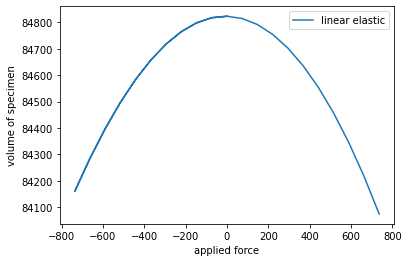

In [14]:
plt.plot(forcelist_lin, volumelist_lin, label="linear elastic")
# plt.plot(forcelist_StVK, volumelist_StVK, label="St Venant Kirchhoff")
# plt.plot(forcelist_neohooke, volumelist_neohooke, label="Neo-Hooke")
# plt.plot(forcelist_MR, volumelist_MR, label="Mooney-Rivlin")
plt.ylabel("volume of specimen")
plt.xlabel("applied force")
plt.legend()

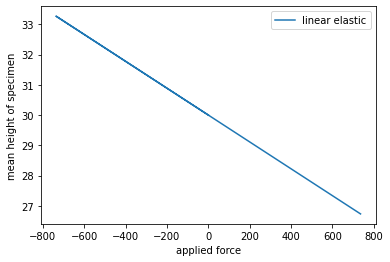

In [15]:
plt.plot(forcelist_lin, meanheightlist_lin, label="linear elastic")
# plt.plot(forcelist_StVK, meanheightlist_StVK, label="St Venant Kirchhoff")
# plt.plot(forcelist_neohooke, meanheightlist_neohooke, label="Neo-Hooke")
# plt.plot(forcelist_MR, meanheightlist_MR, label="Mooney-Rivlin")
plt.ylabel("mean height of specimen")
plt.xlabel("applied force")
plt.legend()